# **Title : Stock Market Trend Prediction using LSTM**

# Project Overview
The goal is to build a deep learning model that predicts whether the next 5 data points (candles) will indicate an uptrend, downtrend, or neutral trend. Use standard libraries, and be accompanied by clear documentation.

## Step 1: Data Collection / Data cleaning / Data Preprocessing
* import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# load the datasets
# dataset file `large_32.csv`. This file contains historical stock market data

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/large_32.csv', parse_dates=['Date Time'])

In [3]:
# Sample of the datasets
df.sample(5)

,Date Time,Open,High,Low,Close,Volume,SMA 5,SMA 10,SMA 50,RSI 14,...,ALLIGATOR JAW,ALLIGATOR TEETH,ALLIGATOR LIPS,EMA 9,KAMA,KAMA COLOR,ATR,RMA 14,SMOOTH MA 14,WMA 14
20974,2024-03-20 13:19:00,21903.80,21908.15,21899.95,21906.10,0,21905.22,21905.77,21879.56,67.434737,...,21872.23,21873.81,21902.50,21902.68,21904.03804,1,8.243461,21891.03337,21891.03,21903.77952
49349,2024-07-15 09:35:00,24557.80,24565.20,24552.80,24562.00,0,24559.29,24559.33,24526.52,57.315462,...,24513.03,24542.77,24557.76,24558.68,24549.49975,1,14.694136,24548.04438,24548.04,24558.98429
35684,2024-05-22 13:05:00,22575.45,22576.80,22572.00,22573.70,0,22571.68,22565.66,22565.94,60.056419,...,22563.33,22561.94,22566.96,22568.68,22565.94747,1,6.709705,22564.85328,22564.85,22566.76619
15913,2024-02-29 11:58:00,21966.05,21967.20,21950.50,21952.95,0,21958.23,21955.01,21953.82,49.639278,...,21949.92,21953.54,21956.00,21956.15,21949.96336,1,10.488370,21953.55624,21953.56,21955.25476
81095,2024-11-14 12:41:00,23520.90,23529.10,23520.20,23526.80,0,23520.69,23522.31,23529.97,49.265953,...,23536.54,23535.88,23522.06,23523.19,23527.54059,-1,8.475188,23527.61587,23527.62,23522.42238


In [4]:
# information of the Datasets
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92514 entries, 0 to 92513
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date Time             92514 non-null  datetime64[ns]
 1   Open                  92514 non-null  float64       
 2   High                  92514 non-null  float64       
 3   Low                   92514 non-null  float64       
 4   Close                 92514 non-null  float64       
 5   Volume                92514 non-null  int64         
 6   SMA 5                 92514 non-null  float64       
 7   SMA 10                92514 non-null  float64       
 8   SMA 50                92514 non-null  float64       
 9   RSI 14                92514 non-null  float64       
 10  MACD LINE             92514 non-null  float64       
 11  MACD SIGNAL           92514 non-null  float64       
 12  MACD HISTOGRAM        92514 non-null  float64       
 13  BOLLINGER BAND S

In [5]:
# Check the null value present or not in the Datasets
df.isnull().sum()

,0
Date Time,0
Open,0
High,0
Low,0
Close,0
Volume,0
SMA 5,0
SMA 10,0
SMA 50,0
RSI 14,0


In [6]:
# Check the duplicate value present or not in the Datasets
df.duplicated().sum()

np.int64(0)

In [7]:
# Set datetime as index
df.set_index('Date Time', inplace=True)

## Step 2: Generate Labels for Next 5-Candle Trend
We define the label based on the next 5 candles:

* Uptrend (0): All 5 candles have Close > Open

* Downtrend (1): All 5 candles have Close < Open

* Neutral (2): Mixed or ne

In [8]:
# Create labels by shifting future 5-candle windows
def generate_labels(df):
    labels = []
    for i in range(len(df) - 5):
        next_5 = df.iloc[i+1:i+6]
        greens = (next_5['Close'] > next_5['Open']).all()
        reds = (next_5['Close'] < next_5['Open']).all()
        if greens:
            labels.append(0)   # Uptrend
        elif reds:
            labels.append(1)   # Downtrend
        else:
            labels.append(2)   # Neutral
    labels.extend([np.nan]*5)
    return labels

df['Label'] = generate_labels(df)
df = df.dropna(subset=['Label'])
df['Label'] = df['Label'].astype(int)
df.head(8)

,Open,High,Low,Close,Volume,SMA 5,SMA 10,SMA 50,RSI 14,MACD LINE,...,ALLIGATOR TEETH,ALLIGATOR LIPS,EMA 9,KAMA,KAMA COLOR,ATR,RMA 14,SMOOTH MA 14,WMA 14,Label
Date Time,,,,,,,,,,,,,,,,,,,,,
2024-01-01 09:15:00,21727.75,21737.35,21701.80,21712.00,0,21728.43,21726.69,21725.91,40.436132,-0.48,...,21729.23,21726.73,21725.82,21728.74373,-1,11.198768,21726.67036,21726.67,21726.13333,2
2024-01-01 09:16:00,21711.50,21720.00,21695.35,21695.65,0,21721.38,21723.72,21725.55,33.330775,-2.89,...,21728.76,21722.92,21719.79,21725.60922,-1,12.159570,21724.45462,21724.45,21722.13952,2
2024-01-01 09:17:00,21697.70,21711.75,21694.75,21709.55,0,21716.03,21722.23,21725.51,42.570024,-3.63,...,21727.50,21718.98,21717.74,21725.22943,-1,12.505315,21723.39001,21723.39,21720.28095,2
2024-01-01 09:18:00,21709.55,21712.50,21698.40,21699.55,0,21709.01,21719.84,21725.37,38.442473,-4.97,...,21726.37,21716.28,21714.10,21724.65038,-1,12.619221,21721.68715,21721.69,21717.28714,2
2024-01-01 09:19:00,21704.35,21708.00,21693.55,21693.75,0,21702.10,21716.85,21725.13,36.247261,-6.42,...,21726.15,21713.18,21710.03,21722.09007,-1,12.749991,21719.69164,21719.69,21713.74619,2
2024-01-01 09:20:00,21693.90,21701.05,21686.05,21687.90,0,21697.28,21712.85,21724.73,34.130277,-7.96,...,21725.28,21709.25,21705.61,21718.83297,-1,12.910706,21717.42081,21717.42,21709.60524,2
2024-01-01 09:21:00,21688.05,21695.90,21684.75,21694.70,0,21697.09,21709.24,21724.45,38.617952,-8.52,...,21724.94,21705.47,21703.42,21717.38768,-1,12.784941,21715.79789,21715.80,21706.72762,2
2024-01-01 09:22:00,21694.30,21700.40,21692.45,21693.35,0,21693.85,21704.94,21724.02,38.063513,-8.97,...,21725.05,21703.66,21701.41,21715.85378,-1,12.439588,21714.19447,21714.19,21703.95333,2


## Step 3: Select Features and Normalize
* Select relevant features (all technical indicators and prices except 'Date Time' and 'Label'), then normalize using StandardScaler

In [9]:
feature_cols = [col for col in df.columns if col not in ['Date Time', 'Label']]
X_raw = df[feature_cols].values
y_raw = df['Label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

## Step 4: Create Time-Series Sequences for LSTM
* We use a sliding window over past timesteps to predict the label.
* Define a window size (e.g., 30 past candles).
* Prepare 3D input tensor shape = (samples, window_size, features)

In [10]:
def make_sequences(X, y, window=30):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

window_size = 30
X, y = make_sequences(X_scaled, y_raw, window=window_size)
print(X.shape, y.shape)

(92479, 30, 25) (92479,)


## Step 5: Split Data into Train, Validation, and Test Sets


In [11]:
train_end = int(len(X) * 0.8)
val_end = int(len(X) * 0.9)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

## Step 6: Build LSTM Model
* This LSTM model learns time-based dependencies in stock data to predict future trends while the dropout layer prevents overfitting, improving generalization and stability in predictions

In [12]:
model = tf.keras.models.Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),

    Dense(32, activation='relu'),

    Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,219 (98.51 KB)

 Trainable params: 25,219 (98.51 KB)

 Non-trainable params: 0 (0.00 B)

## Step 7: Train the Model
* uses early stopping to automatically halt LSTM training when the validation loss stops improving for 10 consecutive epochs, restoring the best-performing weights to prevent overfitting.
* It ensures efficient training and better model generalization by avoiding unnecessary epochs




In [13]:
y_train_cat = to_categorical(y_train, 3)
y_val_cat = to_categorical(y_val, 3)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train_cat,
                    validation_data=(X_val, y_val_cat),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stop],
                    verbose=1
                    )

Epoch 1/50
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.9233 - loss: 0.3155 - val_accuracy: 0.9350 - val_loss: 0.2868
Epoch 2/50
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9427 - loss: 0.2629 - val_accuracy: 0.9350 - val_loss: 0.2862
Epoch 3/50
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9418 - loss: 0.2659 - val_accuracy: 0.9350 - val_loss: 0.2857
Epoch 4/50
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.9427 - loss: 0.2616 - val_accuracy: 0.9350 - val_loss: 0.2884
Epoch 5/50
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.9433 - loss: 0.2593 - val_accuracy: 0.9350 - val_loss: 0.2871
Epoch 6/50
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.9427 - loss: 0.2607 - val_accuracy: 0.9350 - val_loss: 0.2883
Epoch 7/50
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.9422 - loss: 0.2620 - val_accuracy: 0.9350 - val_loss: 0.2866
Epoch 8/50
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9423 -

## Step 8: Evaluate Model
* The classification report provides detailed metrics for each trend class—precision, recall, and F1-score—while the confusion matrix visualizes how well the model distinguishes uptrend, downtrend, and neutral sequences, revealing misclassifications and class-wise performance

289/289 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Uptrend       0.00      0.00      0.00       229
   Downtrend       0.00      0.00      0.00       306
     Neutral       0.94      1.00      0.97      8713

    accuracy                           0.94      9248
   macro avg       0.31      0.33      0.32      9248
weighted avg       0.89      0.94      0.91      9248



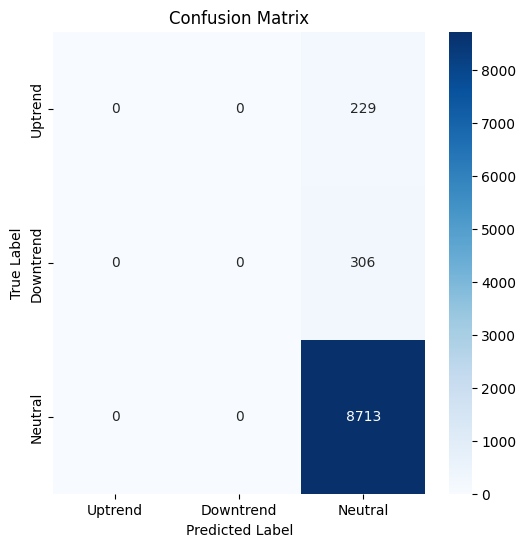

In [14]:
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=['Uptrend', 'Downtrend', 'Neutral']))

import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uptrend', 'Downtrend', 'Neutral'],
            yticklabels=['Uptrend', 'Downtrend', 'Neutral'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


## Step 9: Plot Training History
* It visualizes how well the model learns over time by plotting training and validation loss and accuracy per epoch. If training accuracy keeps improving while validation accuracy stagnates or worsens, it indicates overfitting, prompting early stopping or regularization adjustments for better generalization

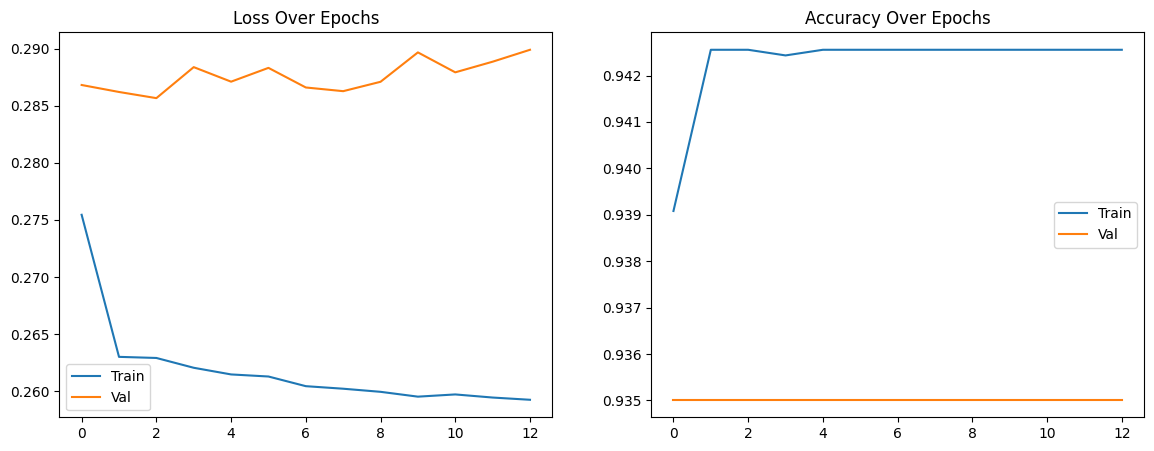

<Figure size 640x480 with 0 Axes>

In [15]:
# Plot accuracy and loss
plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss Over Epochs')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

## Key insights
* Effective Labeling: Transforming raw time-series price data into clear uptrend, downtrend, and neutral multi-candle labels enables sequence learning for actionable trading insights.

* Temporal Dependency: LSTM networks capture complex patterns and dependencies not just from the price but from numerous technical indicators over multiple time windows, improving trend prediction.

* Model Performance: Model accuracy depends heavily on both the lookback window size and the quality of engineered features—careful preprocessing and normalization are critical for deep learning success.

* Visualization: Color-coded plots help visually assess model prediction sequences, revealing both accuracy and periods of ambiguity in trend classification.

* Challenges: Handling data leakage, sequence windowing, and noisy market movements remain major tasks for high-accuracy forecasting; further improvements can come from advanced architectures like Transformers or improved feature engineering.*  